In [1]:
using Pkg
Pkg.activate("deconvolution"; shared=true)

"/Users/imolk/Library/Julia/environments/deconvolution/Project.toml"

In [2]:
using LaTeXStrings
import PyPlot; plt=PyPlot
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
# plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [19]:
using HypothesisTests
using Distributions
import StatsBase

In [4]:
using Revise
import DeconvolveDistribution
import DeconvolutionTests

# Module

In [23]:
module KS
    import DeconvolveDistribution
    using DeconvolveDistribution: FourierDeconv, EfronDeconv
    using HypothesisTests
    using HypothesisTests: ApproximateTwoSampleKSTest, pvalue
    using Distributions
    using StatsBase: sample, midpoints
    using DeconvolutionTests
    using DeconvolutionTests: deconv_boot_test, 
            distance_test_statistic,
            KS_test_statistic, DeconvolutionMethod

    include("../src/simulate.jl")


    function permutation_distrib(X::Vector, Y::Vector, σ_X::Vector, σ_Y::Vector, t::Function; niter=100)
        X_and_Y = cat(X, Y; dims=1)
        t_obs = t(X, Y, σ_X, σ_Y)
        n_X = length(X)
        n_Y = length(Y)
        n_XY = n_X + n_Y
        nabove = 0
        for i in 1:niter
            XY_boot = sample(X_and_Y, n_XY; replace=true)
            Xperm = XY_boot[1:n_X]
            Yperm = XY_boot[n_X+1:end]
            Xtilde = Xperm .+ σ_X.*randn(n_X)
            Ytilde = Yperm .+ σ_Y.*randn(n_Y)
            t_perm = t(Xtilde, Ytilde, σ_X, σ_Y)
            if t_perm > t_obs
                nabove += 1
            end
        end
        return nabove / niter
    end

    function sim_permut(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y, t::Function; kwargs...)
        data = sim_data(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y)
        permutation_distrib(data[:Xtilde], data[:Ytilde], data[:σ_X], data[:σ_Y], t; kwargs...)
    end
    function sim_deconv(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y, t::Function, method::DeconvolutionMethod; kwargs...)
        data = sim_data(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y)
        deconv_boot_test(data[:Xtilde], data[:Ytilde], data[:σ_X], data[:σ_Y], t, method; kwargs...)
    end
    function Luis_cheating_boot_test(Xtilde, Ytilde, σ_X, σ_Y; niter=100)
        X_and_Y = cat(Xtilde, Ytilde; dims=1)
        σ_X_and_Y = cat(σ_X, σ_Y; dims=1)
        
        n_X = length(Xtilde)
        n_Y = length(Ytilde)
        n_XY = n_X + n_Y
        xx = collect(linspace(minimum(X_and_Y)-1.0, maximum(X_and_Y)+1.0, 1000))
        null_CDF = decon(X_and_Y, σ_X_and_Y, 0.3, xx; fixup=true)
        F_X_hat = decon(Xtilde, σ_X, 0.3, xx; fixup=true)
        F_Y_hat = decon(Ytilde, σ_Y, 0.3, xx; fixup=true)
        ϕ_obs = cdf_distance(F_X_hat, F_Y_hat, xx, Inf)
        ϕ_record = Vector{Float64}(niter)
        
        nabove = 0
        for i in 1:niter
            Xboot = [cdf_sample(xx, null_CDF) for _ in 1:n_X]
            Yboot = [cdf_sample(xx, null_CDF) for _ in 1:n_Y]
            Xtilde = Xboot .+ 0.01.*randn(n_X)
            Ytilde = Yboot .+ 0.01.*randn(n_Y)
            ϕ_boot = HypothesisTests.ApproximateTwoSampleKSTest(Xtilde, Ytilde).δ
            if ϕ_boot > ϕ_obs
                nabove += 1
            end
            ϕ_record[i] = ϕ_boot
        end
        return Dict(
            :pvalue => nabove / niter, 
            :obs => ϕ_obs, 
            :bootstrapped => ϕ_record
            )
    end
    function Luis_cheating_sim(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y; kwargs...)
        data = sim_data(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y)
        Luis_cheating_boot_test(data[:Xtilde], data[:Ytilde], data[:σ_X], data[:σ_y]; kwargs...)
    end
end

Main.KS

# Simulate some data

In [37]:
# using a module as a cheap way to encapsulate variables
import Random
Random.seed!(1)
sim_hetero = let 
    F_X = MixtureModel([Normal(-2, 1), Normal(2, 1)], [0.4, 0.6])
    F_Y = Normal(0, 2)
    n_X = 200
    n_Y = 120
    σ_X_distr = Gamma(2.0, 1.0)
    σ_Y_distr = Gamma(2.0, 2.0)
    KS.sim_data(F_X, F_Y, σ_X_distr, σ_Y_distr, n_X, n_Y)
end
;

  likely near /Users/imolk/Library/Julia/packages/IJulia/nBp96/src/kernel.jl:41
┌ Warning: Deprecated syntax `implicit assignment to global variable `n_X``.
│ Use `global n_X` instead.
└ @ nothing none:0
┌ Warning: Deprecated syntax `implicit assignment to global variable `n_Y``.
│ Use `global n_Y` instead.
└ @ nothing none:0


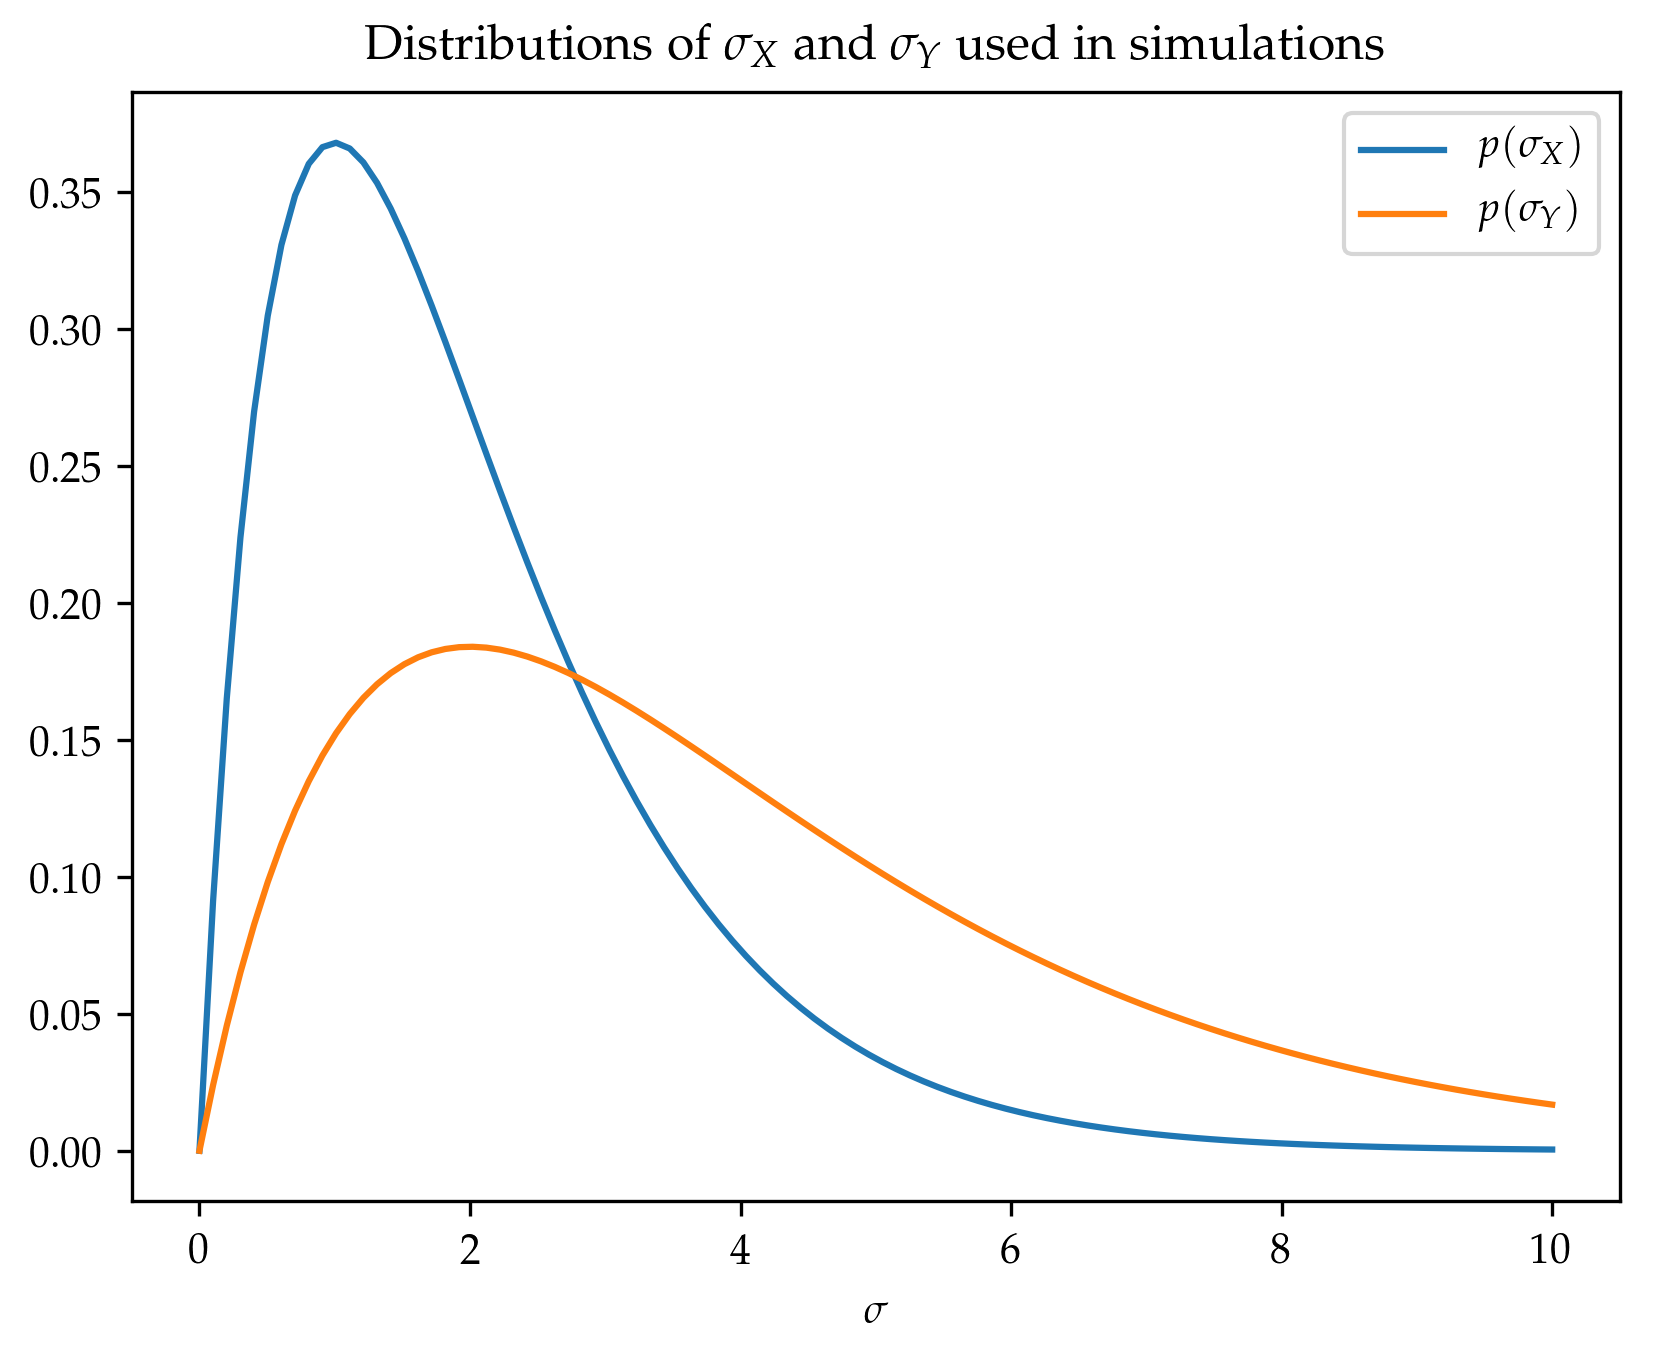

In [11]:
xx = range(0, stop=10, length=100)
plt.plot(xx, pdf.(sim_hetero[:σ_X_distr], xx), label=L"p(\sigma_X)")
plt.plot(xx, pdf.(sim_hetero[:σ_Y_distr], xx), label=L"p(\sigma_Y)")
plt.title(L"Distributions of $\sigma_X$ and $\sigma_Y$ used in simulations")
plt.legend(loc="upper right")
plt.xlabel(L"\sigma")
;

# Testing deconvolution and sampling

In [17]:
xtilde = sim_hetero[:Xtilde]
xx = collect(range(minimum(xtilde)-3.0, stop=maximum(xtilde)+3.0, length=1000))
fourier = DeconvolveDistribution.FourierDeconv(0.3, xx, 200)
F = DeconvolveDistribution.decon(fourier, xtilde, Normal.(0.0, sim_hetero[:σ_X]))
F_samples = [KS.rand(F) for _ in 1:1000000]
;

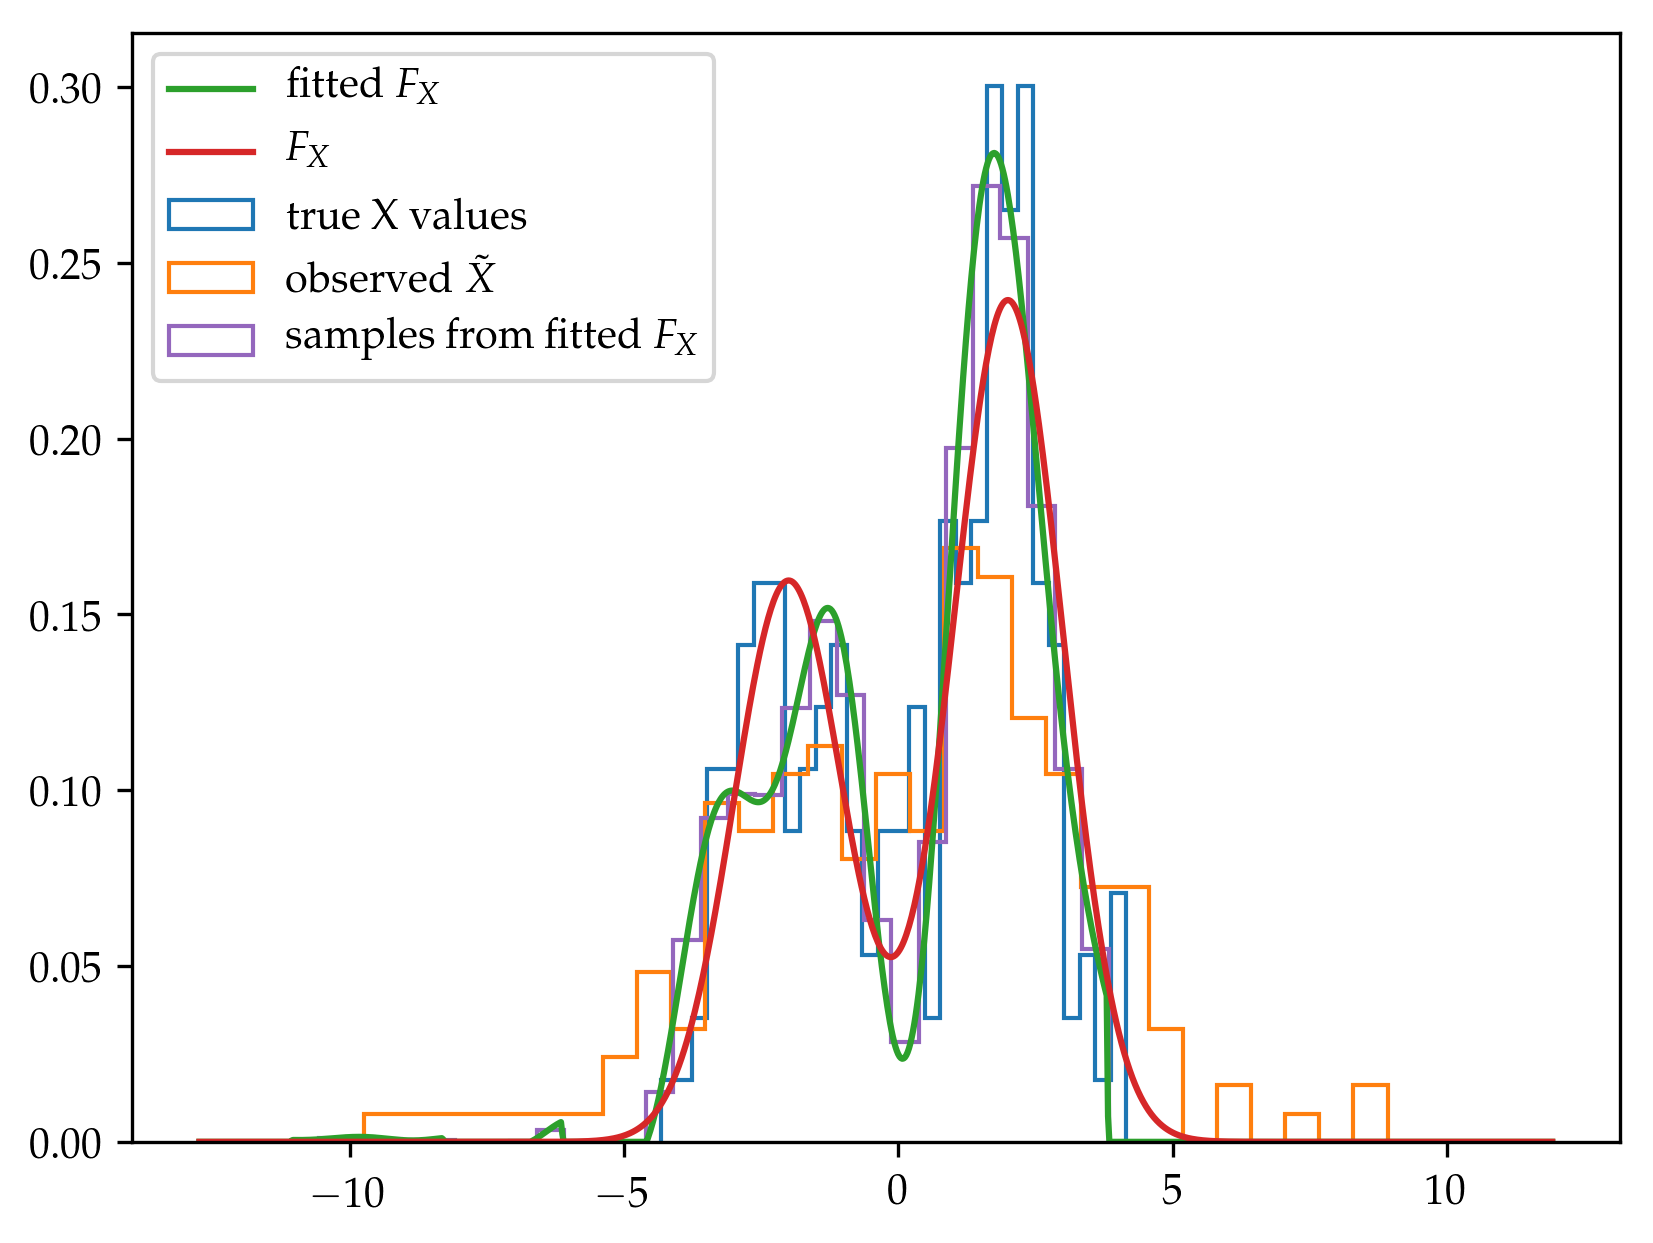

In [21]:
plt.plt[:hist](sim_hetero[:X], histtype="step", normed=true, bins=30, label="true X values")
plt.plt[:hist](sim_hetero[:Xtilde], histtype="step", normed=true, bins=30, label=L"observed $\tilde{X}$")
plt.plot(xx, pdf.(F, xx), label=L"fitted $F_X$")
plt.plot(xx, pdf.(sim_hetero[:F_X], xx), label=L"F_X")
plt.plt[:hist](F_samples, histtype="step", bins=30, normed=true, label=L"samples from fitted $F_X$")
plt.legend(loc="upper left")
;

# Naive permutation test

In [24]:
KS.permutation_distrib(sim_hetero[:Xtilde], sim_hetero[:Ytilde], sim_hetero[:σ_X], sim_hetero[:σ_Y], 
    KS.KS_test_statistic; niter=10000)

0.0788

In [29]:
n_X, n_Y = 200, 100

KS.sim_permut(
    Normal(0, 2), Normal(0, 2), 
    Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
    200, 100, KS.KS_test_statistic; 
    niter=200)

0.05

In [26]:
@time null_pvals_KS = [
    KS.sim_permut(
        Normal(0.0, 2.0), Normal(0.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, KS.KS_test_statistic; 
        niter=400
        ) 
    for _ in 1:1000]
;

 23.053044 seconds (22.98 M allocations: 20.506 GiB, 13.26% gc time)


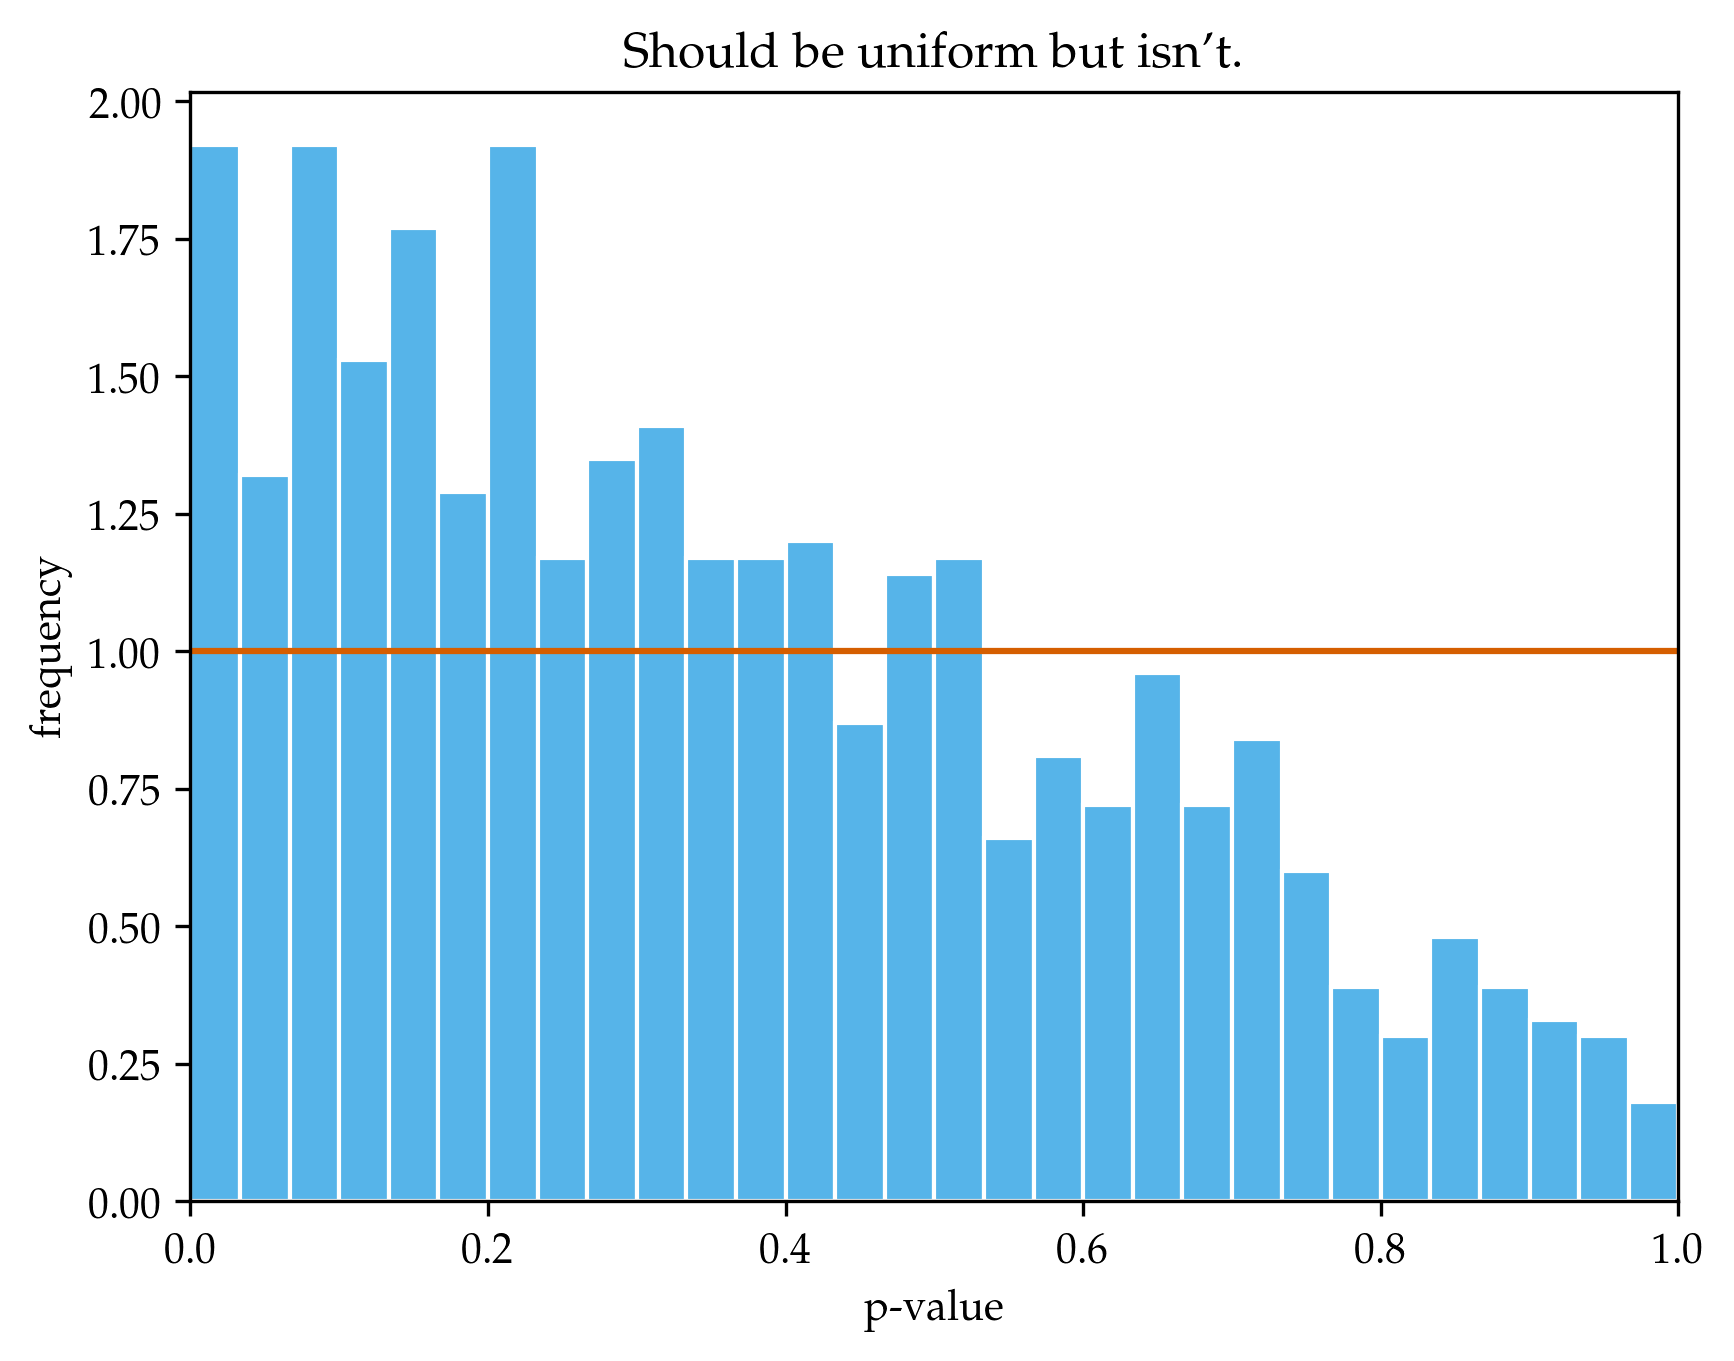

In [27]:
plt.plt[:hist](null_pvals_KS, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Should be uniform but isn't.")
plt.xlim(0, 1)
;

# Deconvolution test

## Under the null: KS statistic

In [34]:
fourier = DeconvolveDistribution.FourierDeconv(0.3, xx, 50)
@time null_pvals_KS_2 = [
    KS.sim_deconv(
        Normal(0.0, 2.0), Normal(0.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, KS.KS_test_statistic,
        fourier
        ; 
        niter=200
        ) 
    for _ in 1:400]
;

 99.380111 seconds (65.66 M allocations: 12.399 GiB, 2.77% gc time)


Previously

    490.908203 seconds (20.87 M allocations: 10.636 GiB, 0.36% gc time)
    
Then improved to

    296.836368 seconds (21.14 M allocations: 10.962 GiB, 0.68% gc time)
    
Then improved to
    
    99.380111 seconds (65.66 M allocations: 12.399 GiB, 2.77% gc time)

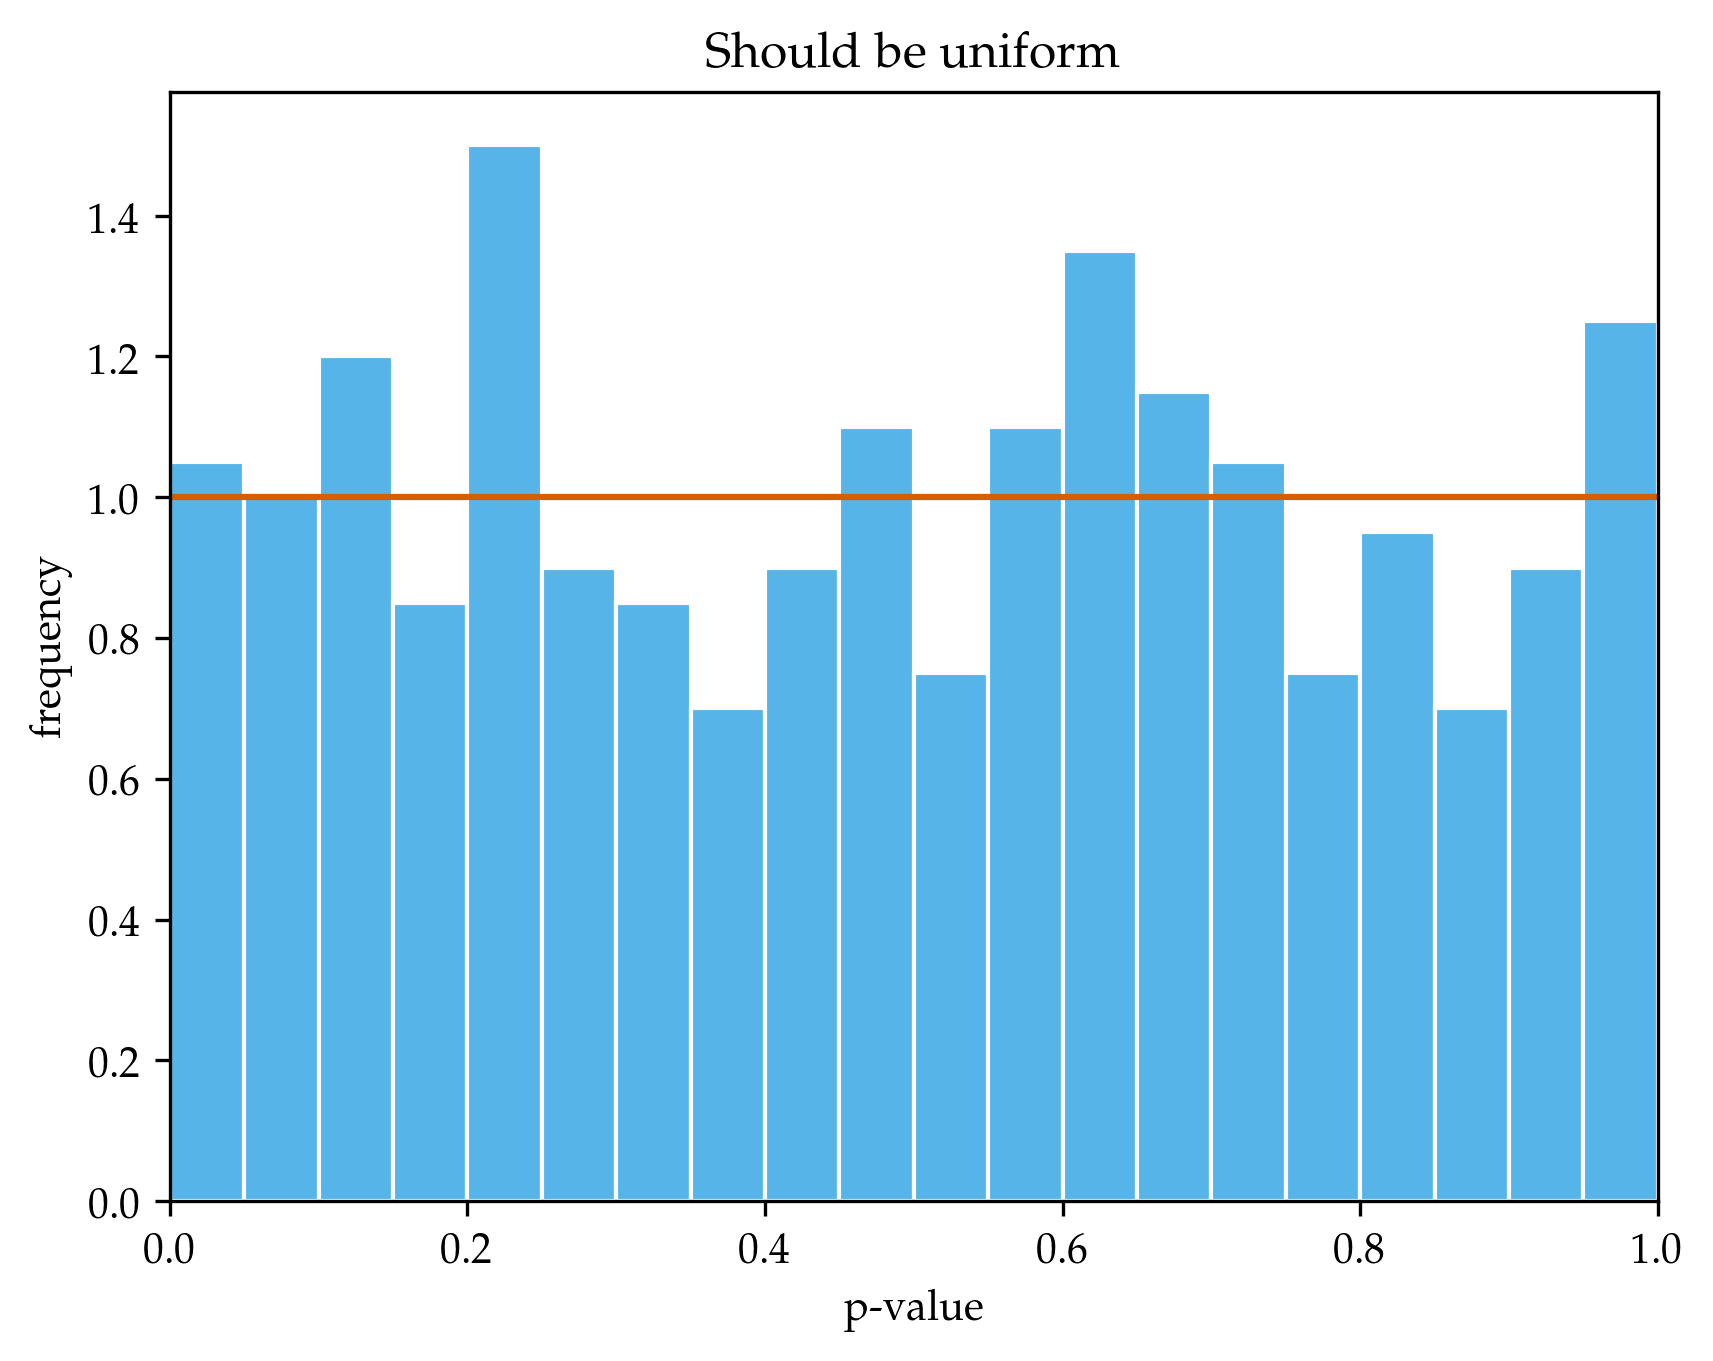

In [35]:
plt.plt[:hist](null_pvals_KS_2, bins=0:0.05:1.0, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Should be uniform")
plt.xlim(0, 1)
;

## Under the alternative: KS statistic

In [31]:
@time alt_pvals_KS = [
    KS.sim_deconv(
        Normal(0.0, 2.0), Normal(1.0, 2.0),
        Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
        n_X, n_Y, KS.KS_test_statistic; 
        niter=400
        ) 
    for _ in 1:400]
;

203.133303 seconds (16.28 M allocations: 8.452 GiB, 0.72% gc time)


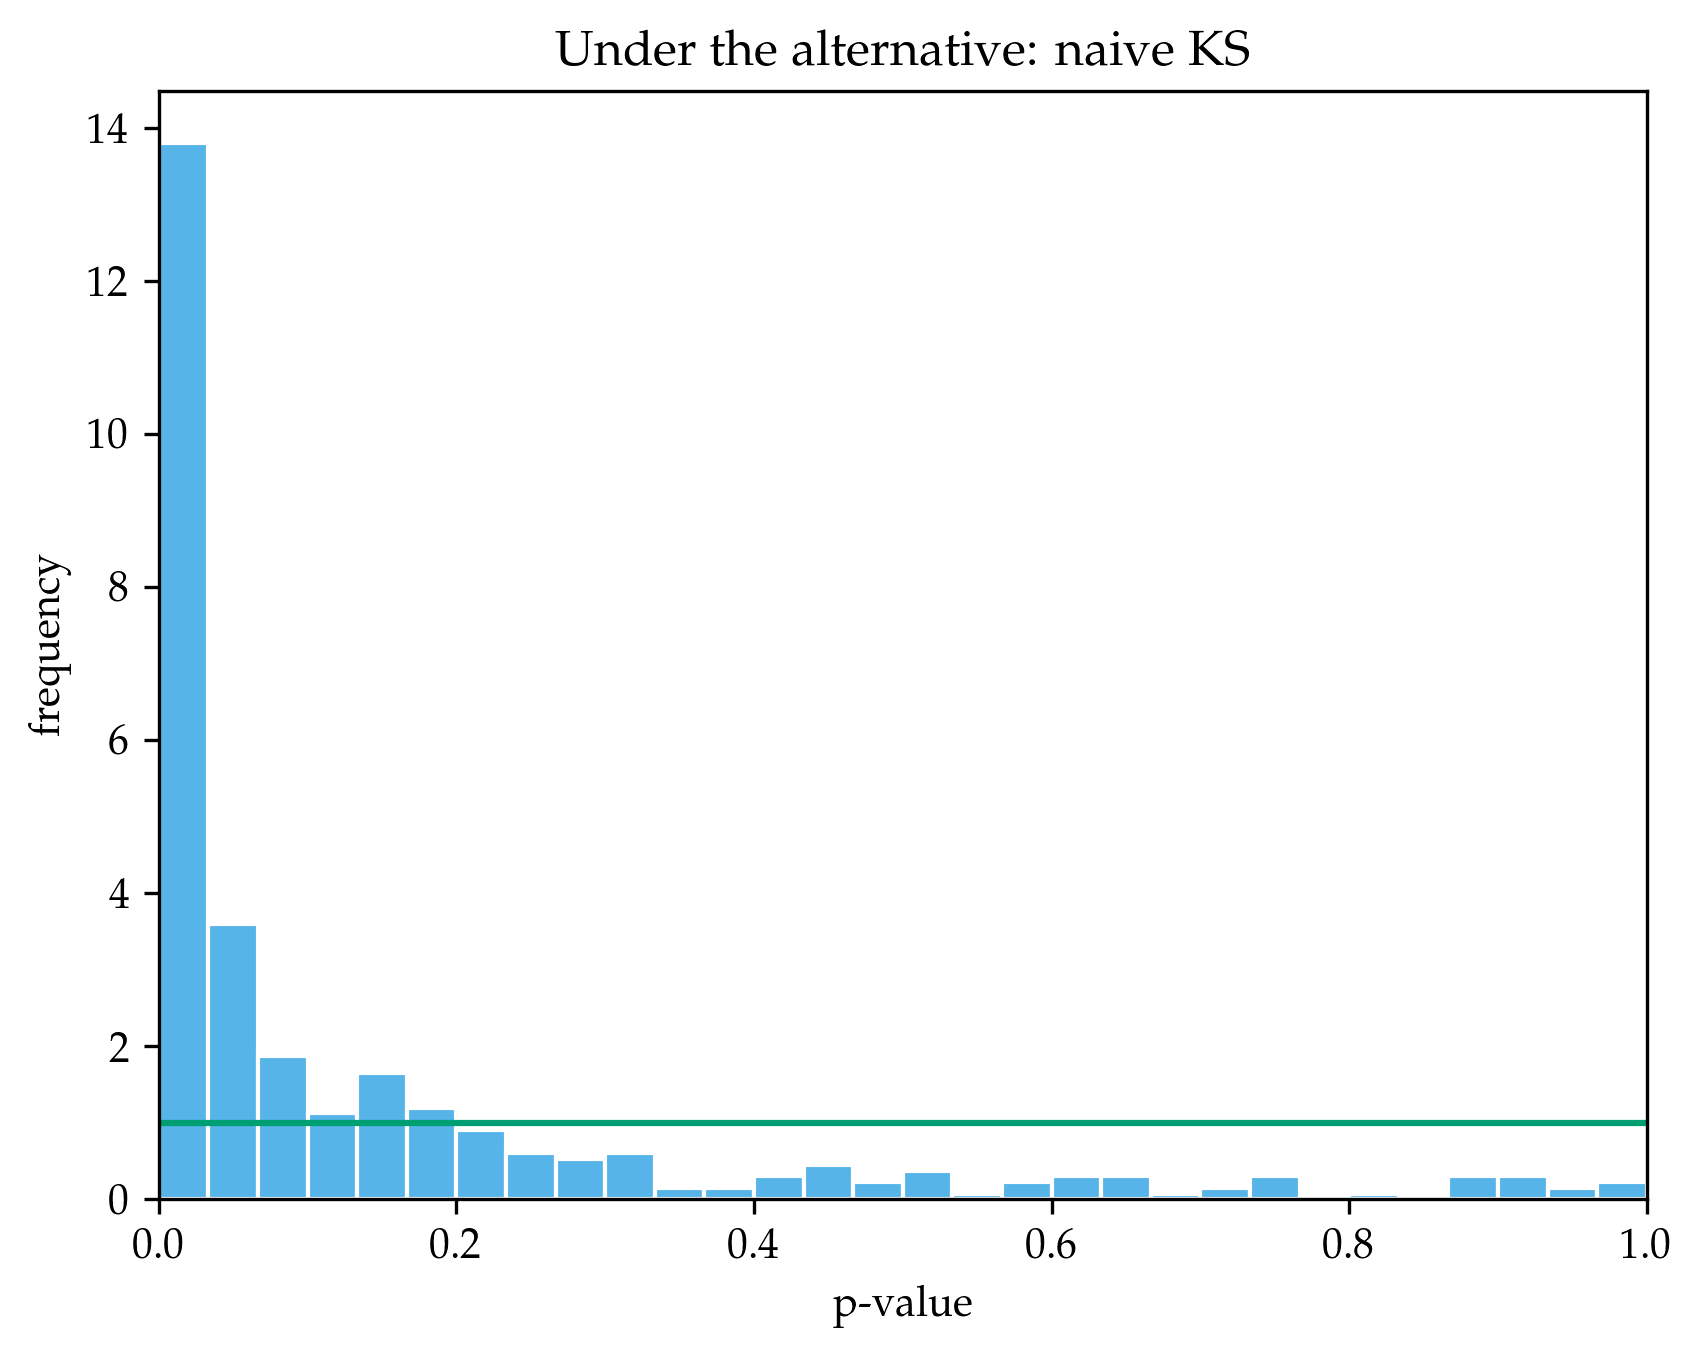

In [48]:
plt.plt[:hist](alt_pvals_KS, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[3])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Under the alternative: naive KS")
plt.xlim(0, 1)
;

## Under the null: deconvolved KS statistic

Note: smaller sample sizes because it's really slow already!

In [33]:
@time null_pvals_L1 = let
    n_X = 100
    n_Y = 150
    p = 1.0
    bw = 0.3
    xgrid = collect(linspace(-10.0, 10.0, 1000))
    t_Lp = KS.distance_test_statistic(p, bw, xgrid)
    pvals = [
        KS.sim_deconv( # perform a single simulation
            Normal(0.0, 2.0), Normal(0.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y, t_Lp; 
            niter=100 # number of *bootstrap* samples
            ) 
        for _ in 1:200]
    pvals
end
;

6808.769595 seconds (23.20 M allocations: 3.056 GiB, 0.01% gc time)


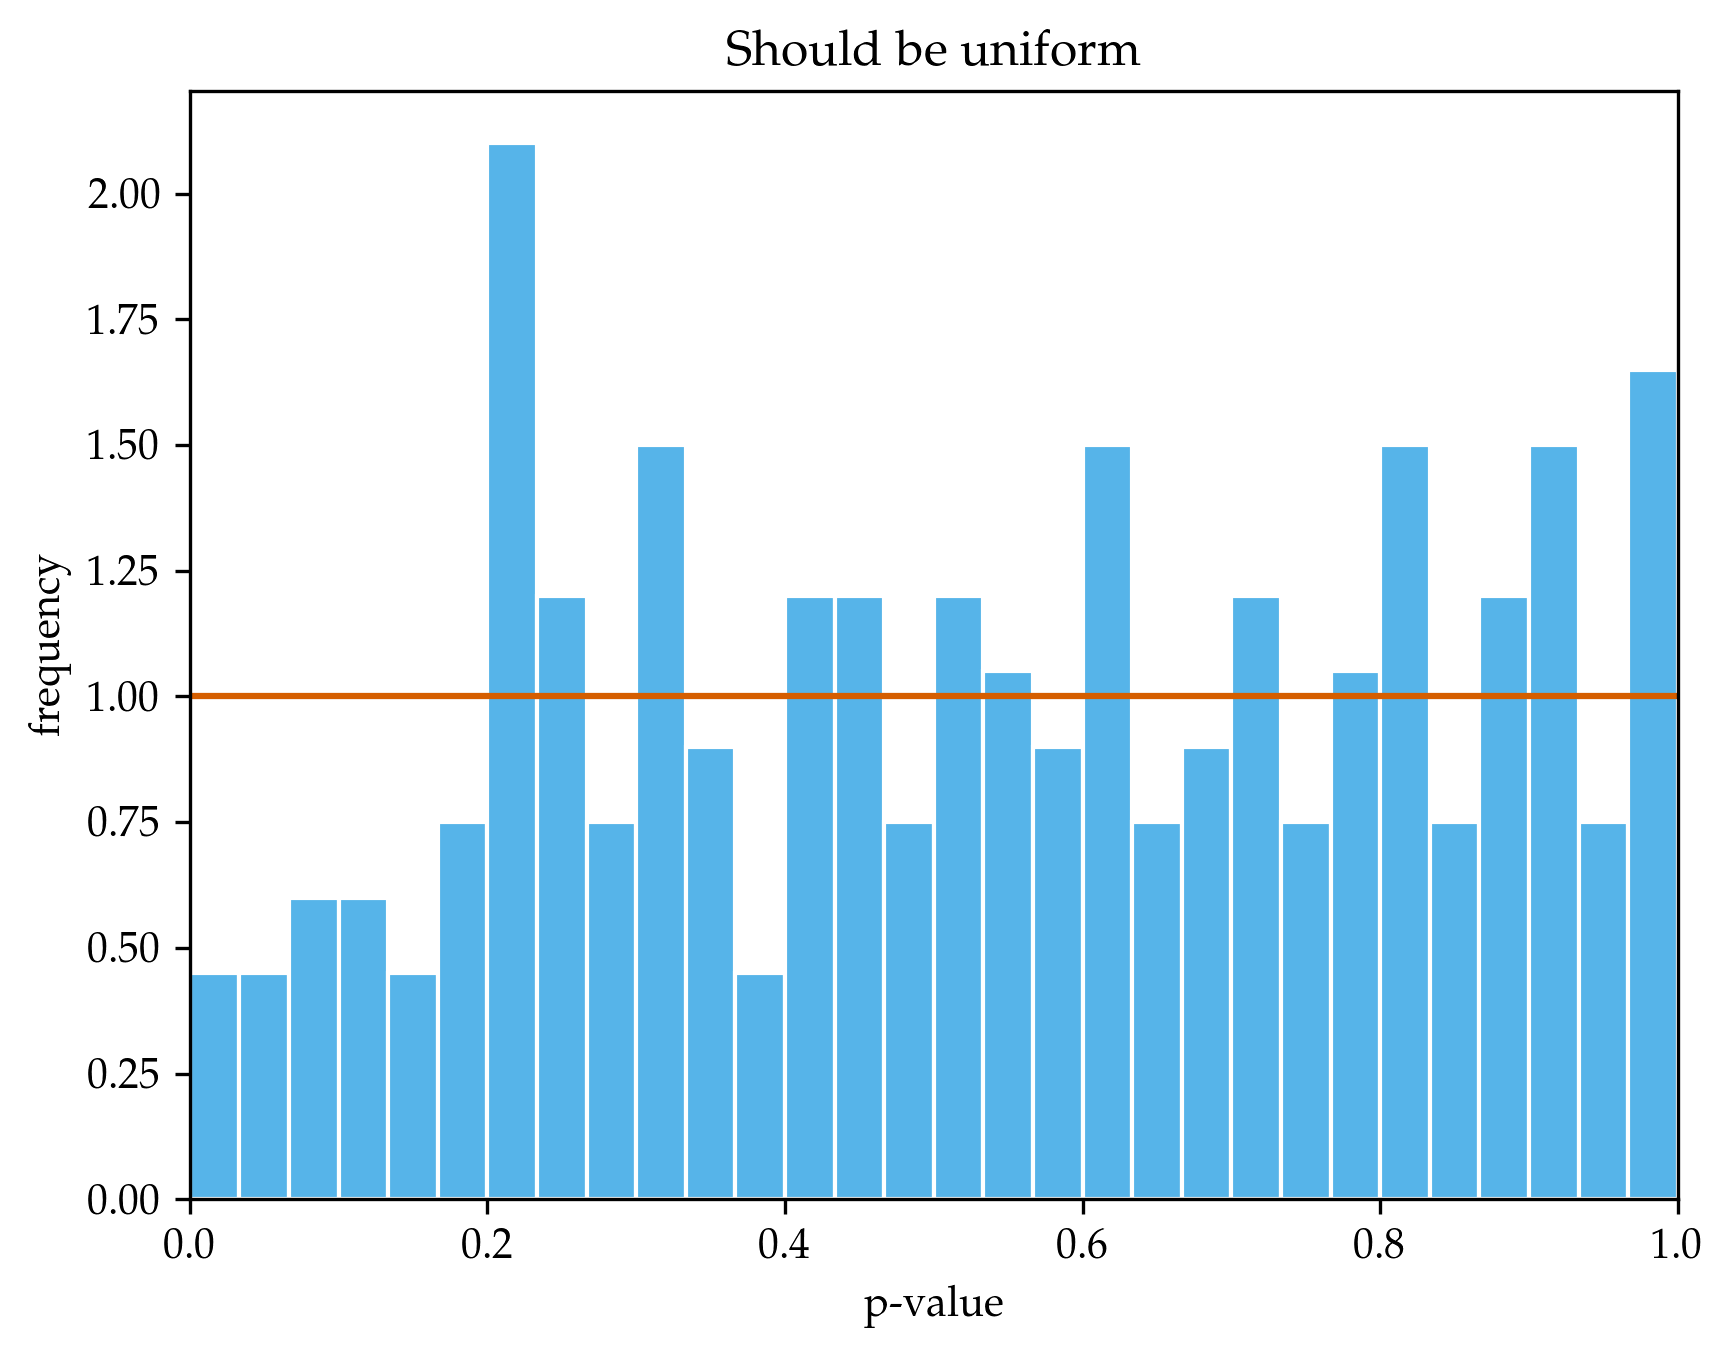

In [34]:
plt.plt[:hist](null_pvals_L1, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Should be uniform")
plt.xlim(0, 1)
;

## Under the alternative: deconvolved KS statistic

In [35]:
@time alt_pvals_L1 = let
    n_X = 100
    n_Y = 150
    p = 1.0
    bw = 0.3
    xgrid = collect(linspace(-10.0, 10.0, 1000))
    t_Lp = KS.distance_test_statistic(p, bw, xgrid)
    pvals = [
        KS.sim_deconv( # perform a single simulation
            Normal(0.0, 2.0), Normal(1.0, 2.0),
            Gamma(2.0, 1.0), Gamma(2.0, 2.0), 
            n_X, n_Y, t_Lp; 
            niter=100 # number of *bootstrap* samples
            ) 
        for _ in 1:200]
    pvals
end
;

6750.519069 seconds (23.17 M allocations: 3.053 GiB, 0.01% gc time)


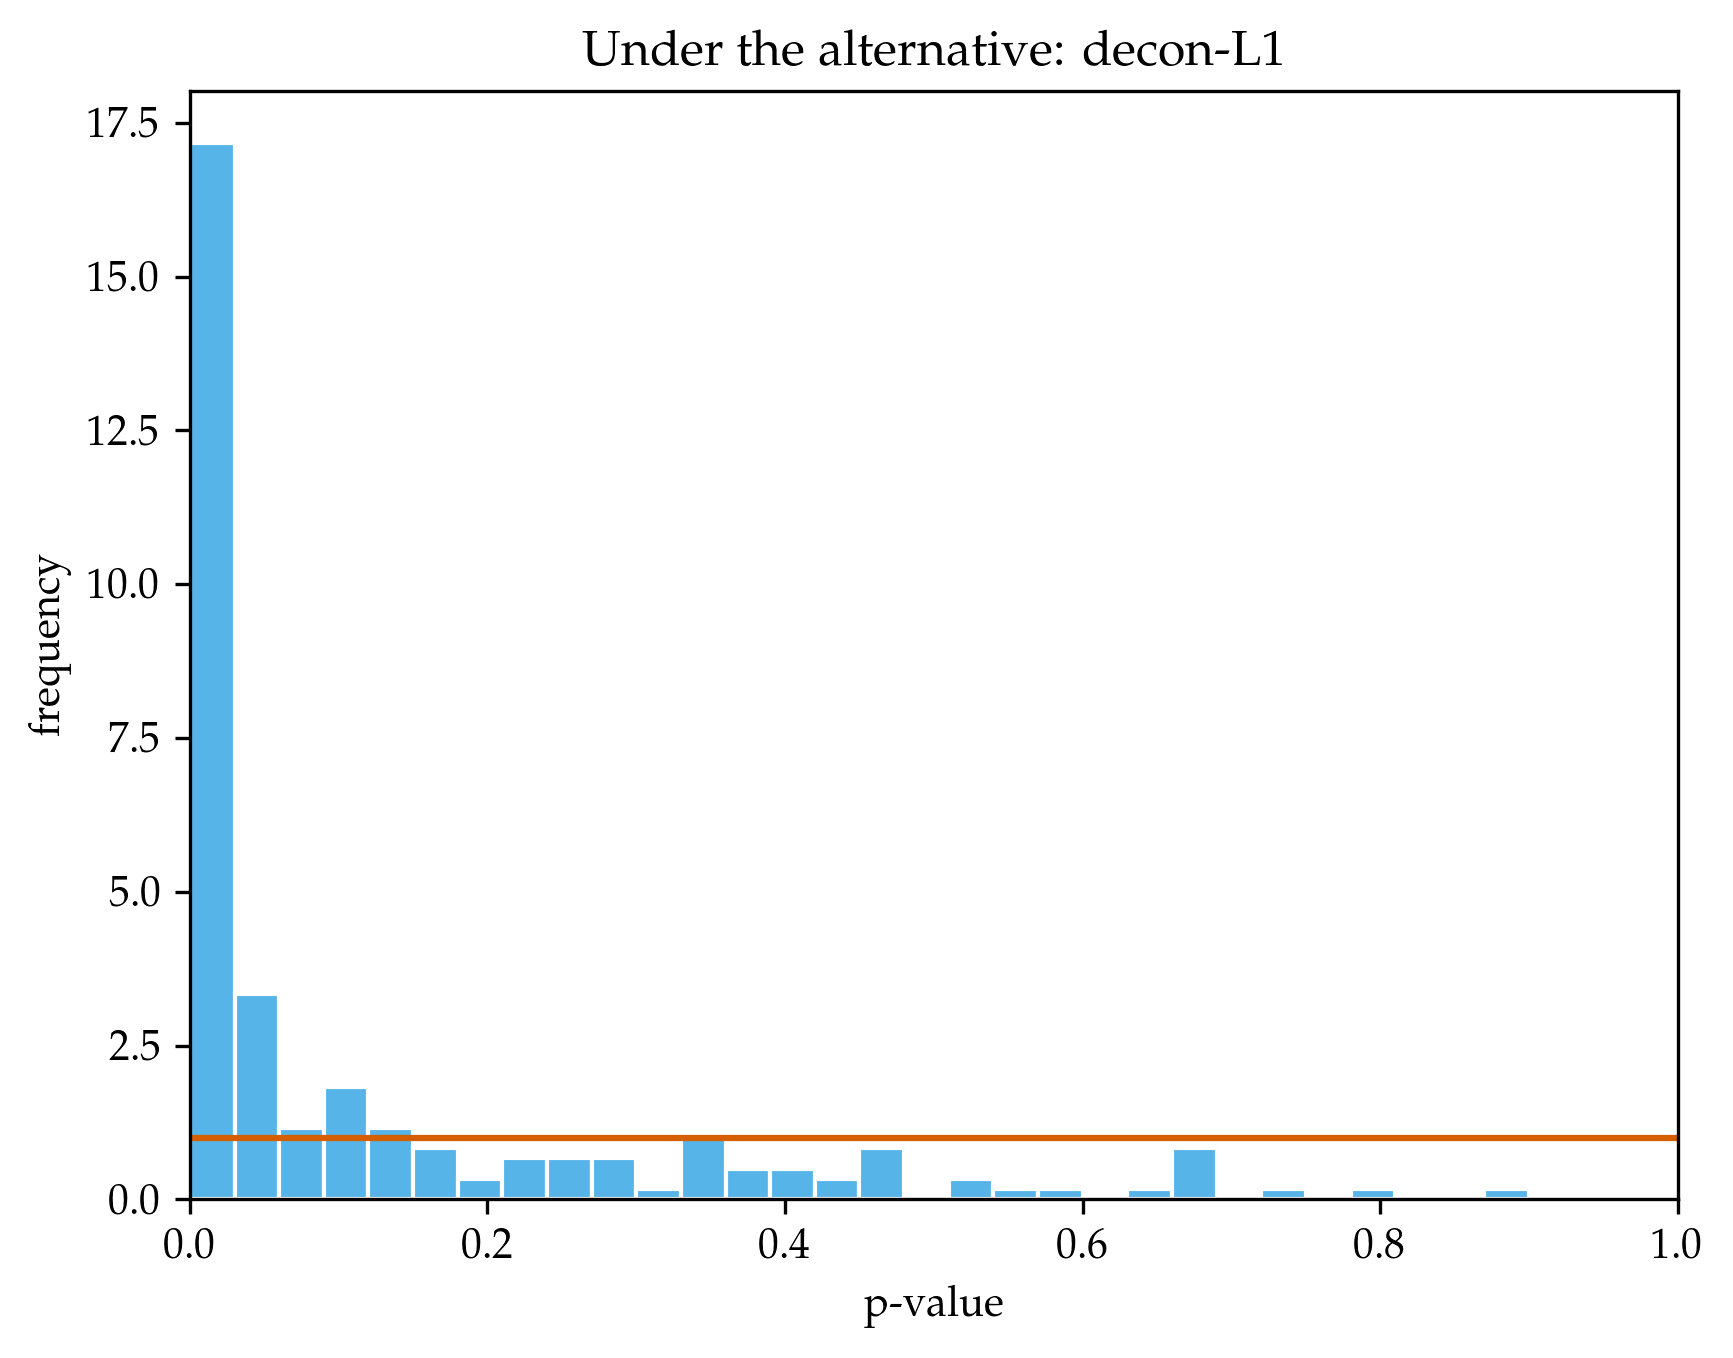

In [37]:
plt.plt[:hist](alt_pvals_L1, bins=30, color=cbbPalette[2], normed=true, edgecolor="white")
plt.axhline(1.0, color=cbbPalette[6])
plt.xlabel("p-value")
plt.ylabel("frequency")
plt.title("Under the alternative: decon-L1")
plt.xlim(0, 1)
;